Task 3. Posterior Sampling in RL task.
----------------------------------------

[Task link](https://arxiv.org/pdf/1306.0940.pdf).

---

### Imports

In [105]:
# necessary utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# torch
import torch
from torch.utils.tensorboard import SummaryWriter

# scipy
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gamma, norm

For this task, I will be using my local machine with CPU.

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## RiverSwin & Q-learning
Taken from [seminar 25](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem25/main.ipynb).

In [107]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000, 
                 rr   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False
    
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return

### Run Q-learning agent for 2 states

I will apply `gaussian_filter1d` to `episode_rewards` for smoothness.

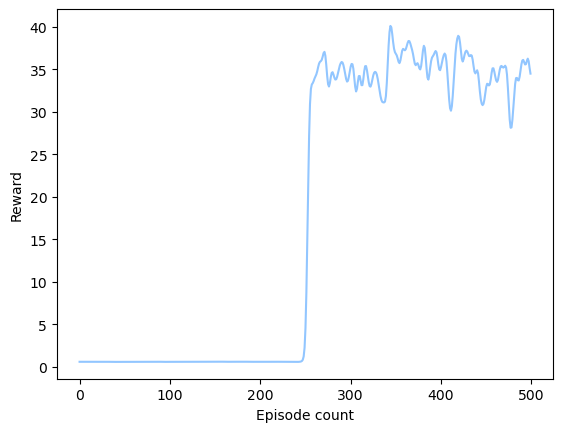

In [108]:
n = 2
ms = 128
total_ep = 500
actions = 2

psrl_AGENT = QLearningAgent(2+n, actions)

rews = []
for episode in range(total_ep):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    psrl_AGENT.start_episode()
    while not is_done:
        action = psrl_AGENT.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        psrl_AGENT.update(state, action, reward, next_state)
        
        state = next_state
        ep_reward += reward
        
    rews.append(ep_reward)

# for smoothness
filtered_episode_rewards = gaussian_filter1d(rews, sigma=2)
plt.style.use('seaborn-v0_8-pastel')
plt.plot(filtered_episode_rewards)
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Now, let's apply and try with more states. I'll range from 4 to 8.

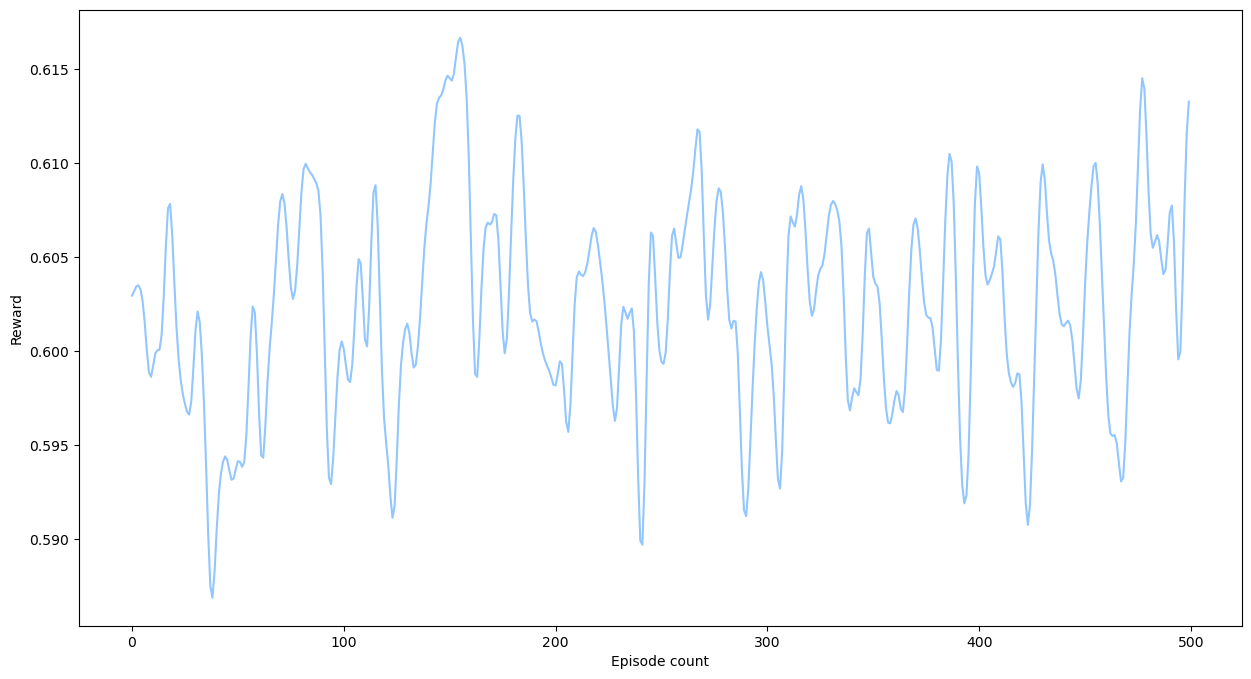

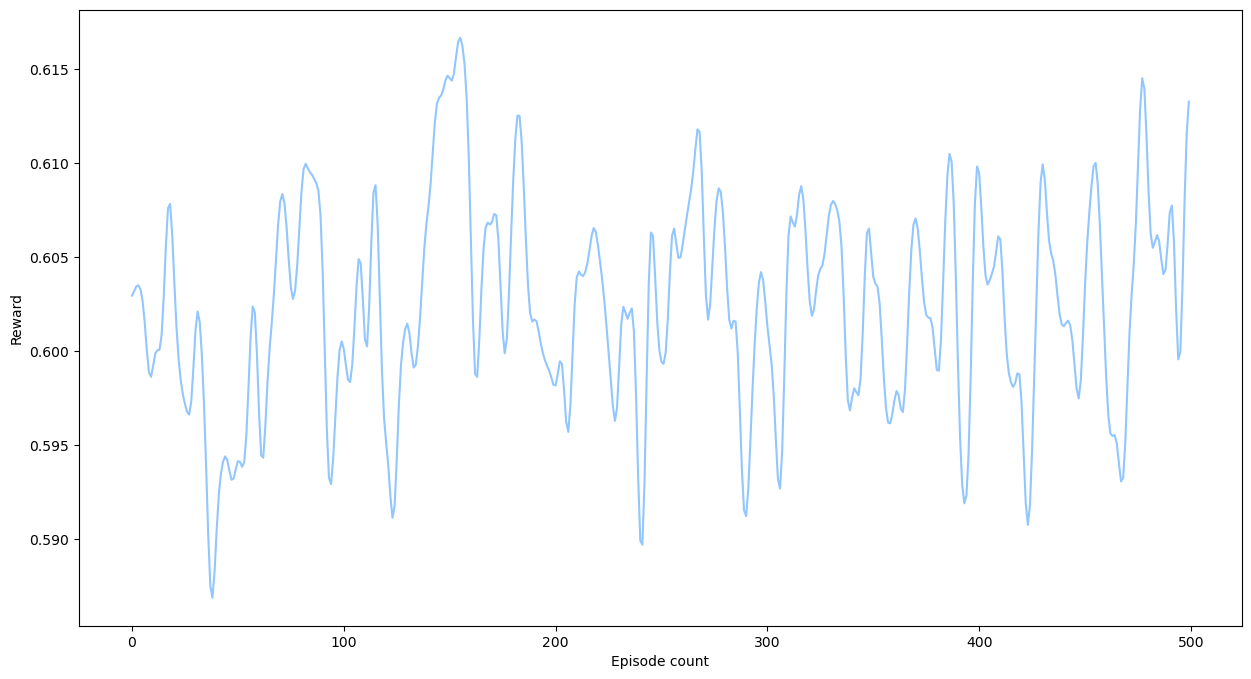

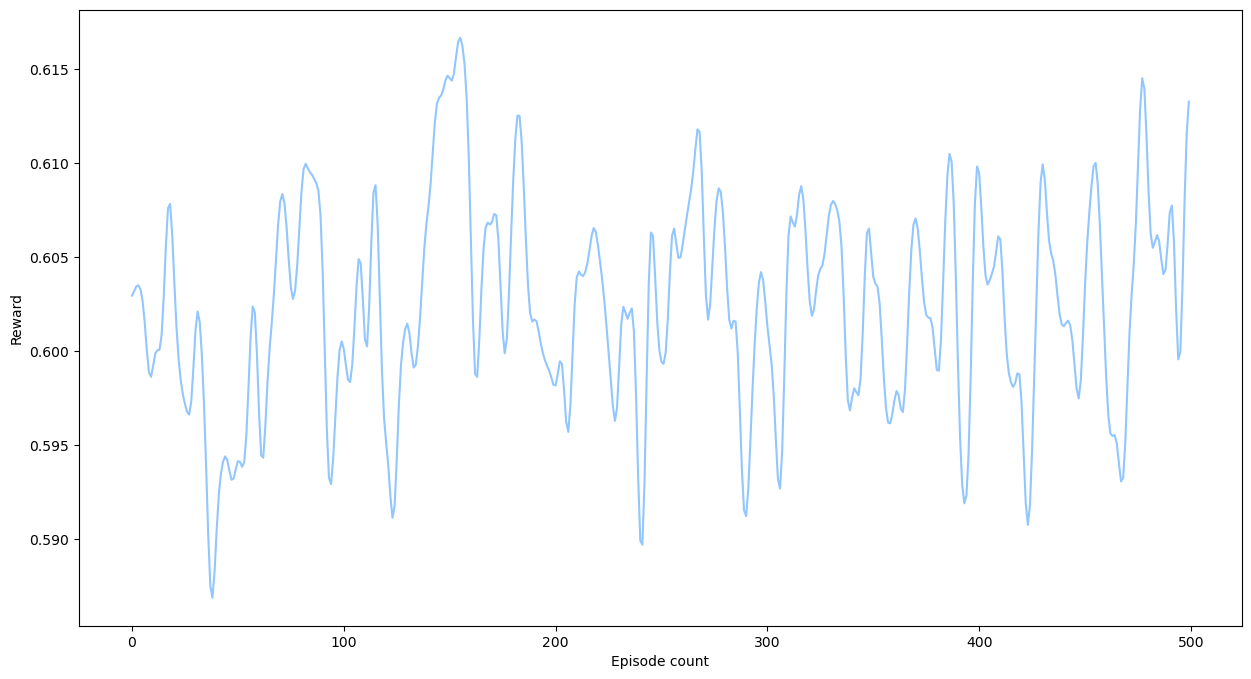

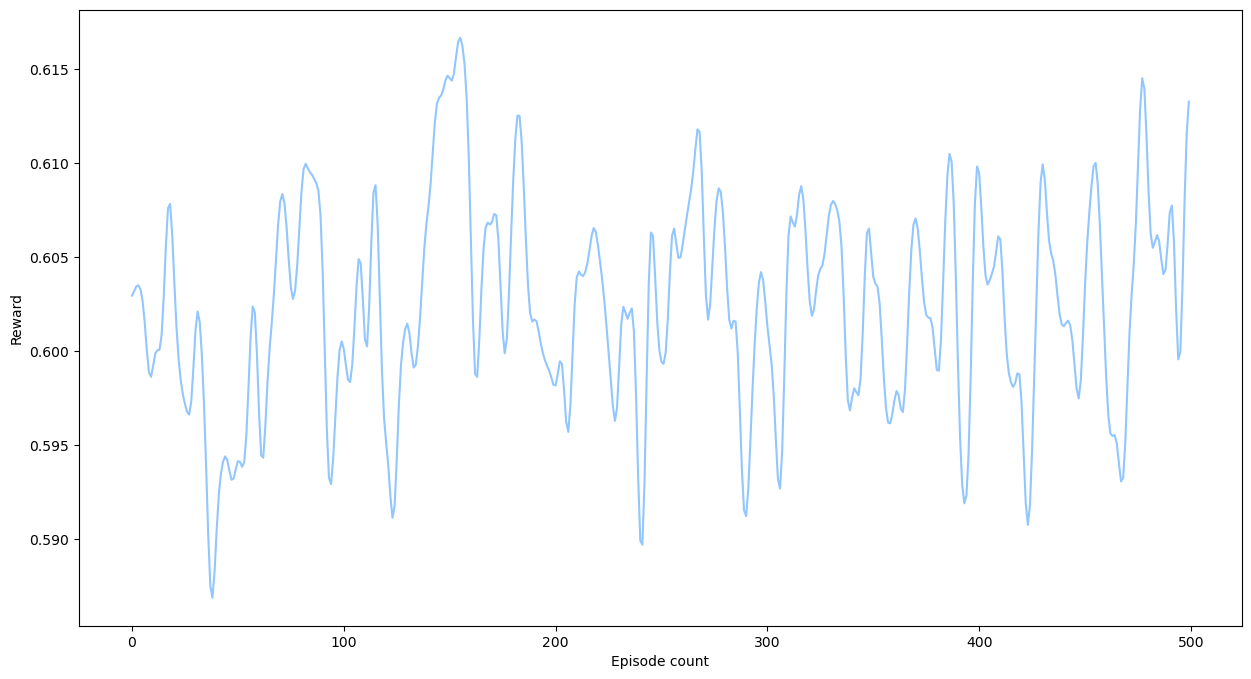

In [109]:
for n in range(4, 8):
    ms = 128
    total_ep = 500
    actions = 2
    
    psrl_AGENT = QLearningAgent(2+n, actions)
    
    rews = []
    for episode in range(total_ep):
        river_swim = RiverSwim(n, ms)
    
        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        psrl_AGENT.start_episode()
        while not is_done:
            action = psrl_AGENT.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            psrl_AGENT.update(state, action, reward, next_state)
            
            state = next_state
            ep_reward += reward
            
        rews.append(ep_reward)

    filtered_episode_rewards = gaussian_filter1d(rews, sigma=2)

    plt.figure(figsize=(15,8))
    plt.style.use('seaborn-v0_8-pastel')
    plt.plot(filtered_episode_rewards)
    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()

### Analyzing graphs

I've found out that Q-learning sometimes doesn't reach the other shore, when given large n-s. There are a few ways to solve this problem.

One of them is a _Posterior Sampling_.

## Posterior Sampling

Posterior Sampling Reinforcement Learning (PSRL)

PSRL is an algorithm designed for agents to learn an optimal policy in an unknown environment. It accomplishes this by sampling a model of the environment, and then acting according to the policy that is optimal under that sampled model. This process is repeated at the beginning of each episode.

### PSRL Algorithm

Here is the PSRL algorithm with explanations for each step:

```pascal
Data: Prior distribution f, t = 1 (time step counter)
for episodes k = 1, 2, ... do
  Sample Mk ∼ f(·|Htk) 
  #This line samples a model Mk of the environment from the prior distribution f, conditioned on the history of observations Htk up to the current episode k. In simpler terms, the agent uses its past experiences (Htk) to update its belief about the environment (Mk).  
  
  compute µk = µMk
  #This line computes the optimal policy µk for the sampled model Mk. The optimal policy refers to the sequence of actions that will maximize the expected reward for the agent in a given environment. 
  
  for timesteps j = 1, ..., τ do
    sample and apply at = µk(st, j)
    # This line uses the optimal policy µk to select an action at for the current state st at timestep j.  
    
    observe rt and st+1
    # This line refers to the agent taking action at and observing the reward rt and the next state st+1. 
    
    t = t + 1
    # This line updates the time step counter t. 
  end
end
```

### PSRL Key Points

- PSRL is computationally efficient because it only requires solving for an optimal policy for a single sampled model of the environment in each episode.
- PSRL allows an agent to incorporate any prior knowledge it may have about the environment through the prior distribution f.

## Building Q-agent

Let's take `Q-learning` class and apply new logic.

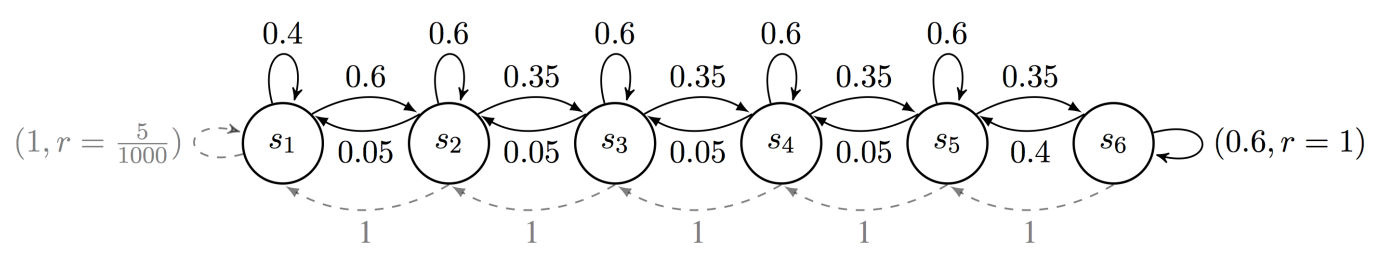
$$\text{RiverSwim (where arrows are MDP with directions)}$$

### Agent actions
_I took description from the internet._
RiverSwim consists of six states arranged in a chain as shown in Figure 1. The agent begins
at the far left state and at every time step has the choice to swim left or right. Swimming left
(with the current) is always successful, but swimming right (against the current) often fails.
The agent receives a small reward for reaching the leftmost state, but the optimal policy is
to attempt to swim right and receive a much larger reward. This MDP is constructed so
that efficient exploration is required in order to obtain the optimal policy.

$$\text{Description from seminars}$$

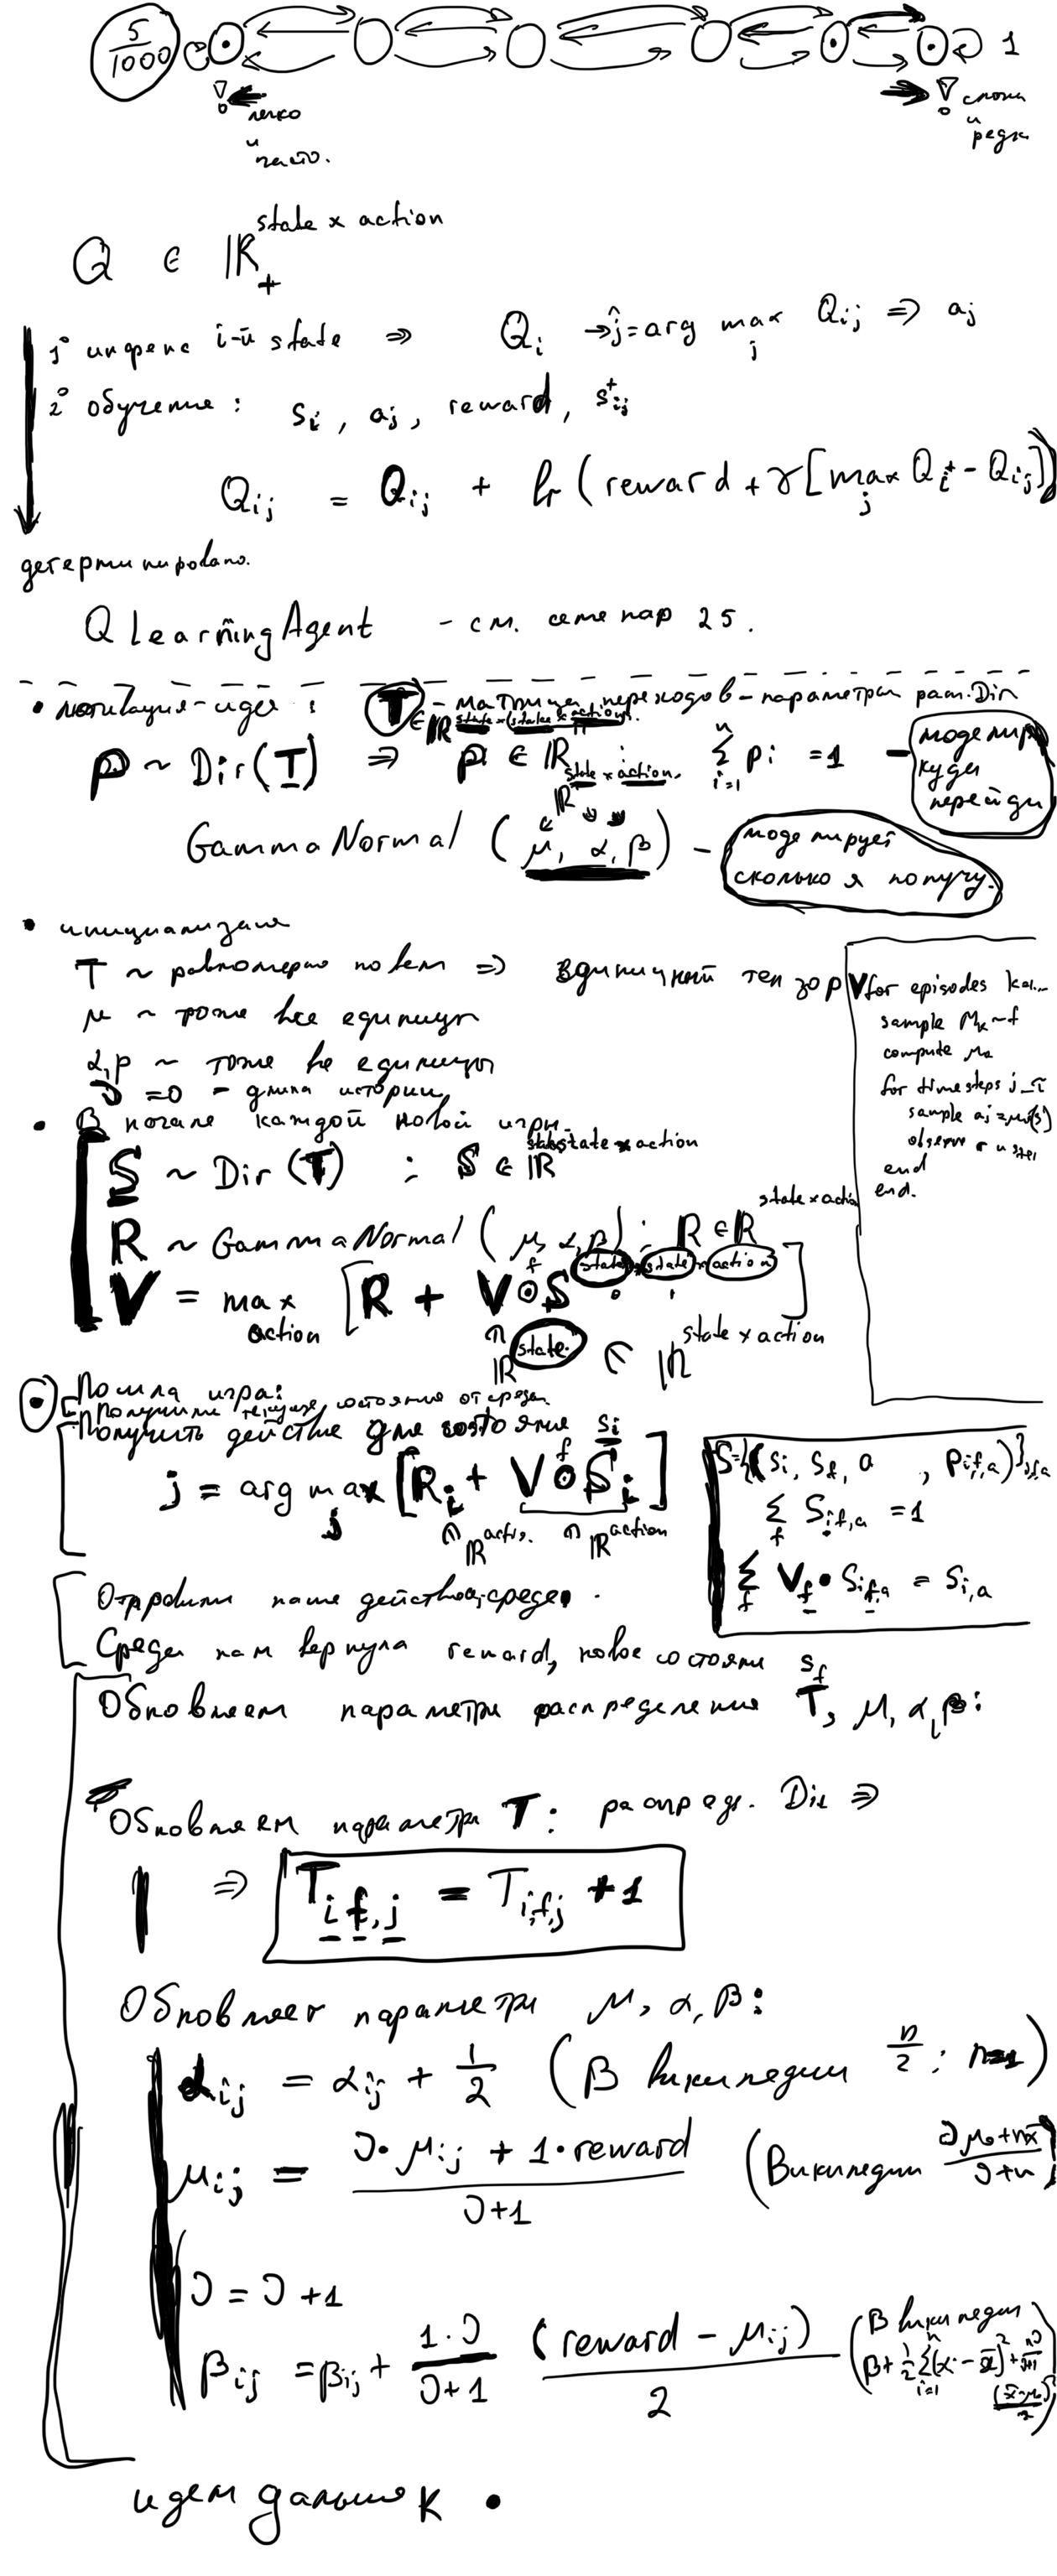

### PSLR agent

In [110]:
class PSRLAgent:
    def __init__(self, num_states, num_actions, seed=42):

        self.rs = np.random.RandomState(seed)

        self.num_states = num_states
        self.num_actions = num_actions

        self.transition_matrix = np.zeros((num_states, num_states, num_actions))

        self.mean_values = np.ones((num_states, num_actions))
        self.gamma_values = np.ones((num_states, num_actions))
        self.alpha_values = np.ones((num_states, num_actions))
        self.beta_values = np.ones((num_states, num_actions))

        self.transition_alpha_coefficients = np.ones((num_states, num_states, num_actions))

        self.action_decision = np.zeros(num_states)

        self.rewards_matrix = np.zeros((num_states, num_actions))

    def choose_action(self, current_state):
        action_vector = self.transition_matrix.transpose(
            0, 2, 1)[current_state] @ self.action_decision

        answer = np.argmax(self.rewards_matrix[current_state] + action_vector)
        return answer

    def update_q_matrix(self):
        delta_rewards = self.calculate_delta_rewards()
        return self.rewards_matrix + delta_rewards

    def calculate_delta_rewards(self):
        return self.transition_matrix.transpose(0, 2, 1) @ self.action_decision

    def create_random_transition_choices(self):
        random_transition_choices = np.array([])
        for state_distribution in self.transition_alpha_coefficients:
            actions_for_states = np.array(
                [np.random.dirichlet(action) for action in state_distribution.T])
            random_transition_choices = np.append(random_transition_choices, actions_for_states)

        shape = self.transition_alpha_coefficients.transpose(0, 2, 1).shape
        random_transition_choices = random_transition_choices.reshape(shape)

        return random_transition_choices

    def start_episode(self):

        random_transition_choices = self.create_random_transition_choices()

        self.transition_matrix = random_transition_choices.transpose(0, 2, 1)

        gamma_distribution = gamma.rvs(
            a=self.alpha_values, scale=1 / self.beta_values, random_state=self.rs)

        self.rewards_matrix = norm.rvs(
            loc=self.mean_values,  scale=1 / np.sqrt(self.gamma_values * gamma_distribution), random_state=self.rs)

        delta_rewards = self.calculate_delta_rewards()
        self.action_decision = np.max(self.rewards_matrix + delta_rewards, axis=1)

        return

    def update(self, i, j, reward, next_state):
        self.transition_alpha_coefficients[i, next_state, j] += 1

        self.alpha_values[i, j] = self.alpha_values[i, j] + 1 / 2
        self.mean_values[i, j] = (
            self.gamma_values[i, j] * self.mean_values[i, j] + 1 * reward) / (self.gamma_values[i, j] + 1
                                                                              )

        self.gamma_values[i, j] = self.gamma_values[i, j] + 1

        self.beta_values[i, j] += (
            (1 * self.gamma_values[i, j]) / (self.gamma_values[i, j] + 1) *
            np.abs(reward - self.mean_values[i, j]) / 2
        )

        return

## Testing 

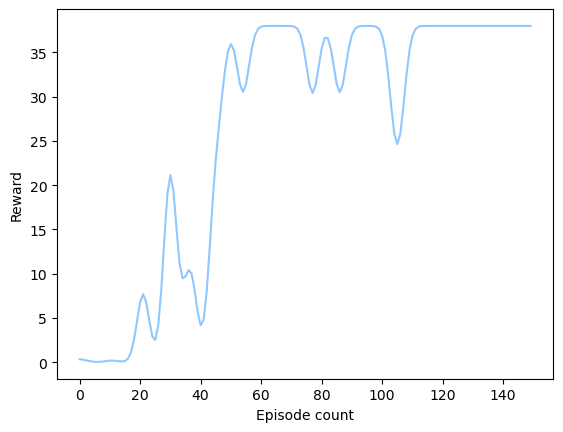

In [111]:
writer_12 = SummaryWriter(log_dir = f'./log/PSRLA_12')
agent = PSRLAgent(12, 2)
rews = []

for episode in range(150):
    # make an agent
    river_swim = RiverSwim(10, 128)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    # action 
    while not is_done:
        action = agent.choose_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward

    rews.append(ep_reward)
    writer_12.add_scalar('Reward/12_states', ep_reward, 0)


filtered_episode_rewards = gaussian_filter1d(rews, sigma=2)
plt.plot(filtered_episode_rewards)
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

### Trying 32 states

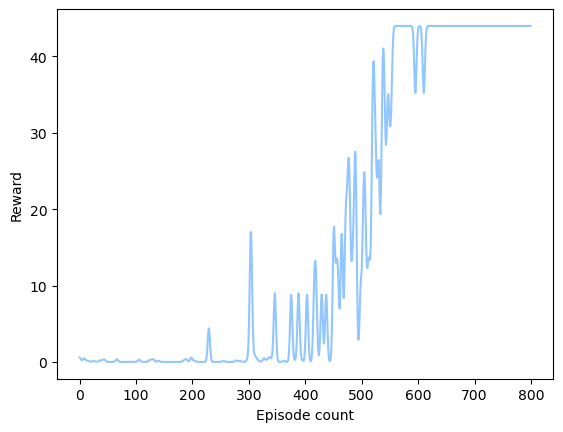

In [112]:
prox_policy_opt_writer = SummaryWriter(log_dir = f'./log/PSLRA_32')

psrl_AGENT = PSRLAgent(32, 2)
rews = []

for episode in range(800):
    river_swim = RiverSwim(30, 228)
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    psrl_AGENT.start_episode()
    
    while not is_done:
        action = psrl_AGENT.choose_action(state)
        next_state, reward, is_done = river_swim.step(action)
        psrl_AGENT.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward

    rews.append(ep_reward)
    prox_policy_opt_writer.add_scalar('Reward/32_states', ep_reward, 0)

filtered_episode_rewards = gaussian_filter1d(rews, sigma=2)

plt.plot(filtered_episode_rewards)
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

## ProximalPolicyOptimizationAgent

Let's store previous states and use previous one.

In [113]:
class ProximalPolicyOptimizationAgent:
    def __init__(self, num_states, num_actions, memory_capacity, seed=42):

        self.random_state = np.random.RandomState(seed)
        self.memory_capacity = memory_capacity
        self.memory = []

        self.num_states = num_states
        self.num_actions = num_actions

        self.transition_distribution_matrix = np.zeros((num_states, num_states, num_actions))

        self.mean = np.ones((num_states, num_actions))
        self.discount_factor = np.ones((num_states, num_actions))
        self.alpha = np.ones((num_states, num_actions))
        self.beta = np.ones((num_states, num_actions))

        self.transition_alphas_coefficients_matrix = np.ones(
            (num_states, num_states, num_actions))

        self.action_decisions = np.zeros(num_states)

        self.rewards_matrix = np.zeros((num_states, num_actions))

    def choose_action(self, current_state):
        action_vector = self.transition_distribution_matrix.transpose(
            0, 2, 1)[current_state] @ self.action_decisions

        decision = np.argmax(self.rewards_matrix[current_state] + action_vector)
        return decision

    def calculate_q_values(self):
        delta = self.calculate_delta_rewards()
        return self.rewards_matrix + delta

    def calculate_delta_rewards(self):
        return self.transition_distribution_matrix.transpose(0, 2, 1) @ self.action_decisions

    def generate_random_dirichlet_choices(self):
        dirichlet_choices = np.array([])
        for state_distribution in self.transition_alphas_coefficients_matrix:
            actions_for_states = np.array(
                [np.random.dirichlet(action) for action in state_distribution.T])
            dirichlet_choices = np.append(dirichlet_choices, actions_for_states)

        shape = self.transition_alphas_coefficients_matrix.transpose(0, 2, 1).shape
        dirichlet_choices = dirichlet_choices.reshape(shape)

        return dirichlet_choices

    def begin_episode(self):

        dirichlet_choices = self.generate_random_dirichlet_choices()

        self.transition_distribution_matrix = dirichlet_choices.transpose(0, 2, 1)

        gamma_distribution = gamma.rvs(
            a=self.alpha, scale=1 / self.beta, random_state=self.random_state)

        self.rewards_matrix = norm.rvs(
            loc=self.mean, scale=1 / np.sqrt(self.discount_factor * gamma_distribution), random_state=self.random_state)

        delta = self.calculate_delta_rewards()
        self.action_decisions = np.max(self.rewards_matrix + delta, axis=1)

        return

    def update(self, state, action, reward, next_state):
        self.memory.append([state, action])

        for [s, act] in self.memory[-self.memory_capacity:]:
            self.transition_alphas_coefficients_matrix[s, next_state, act] += 1

        self.alpha[state, action] = self.alpha[state, action] + 1 / 2
        self.mean[state, action] = (
            self.discount_factor[state, action] * self.mean[state, action] + 1 * reward) / (self.discount_factor[state, action] + 1
        )

        self.discount_factor[state, action] = self.discount_factor[state, action] + 1

        self.beta[state, action] += (
            (1 * self.discount_factor[state, action]) / (self.discount_factor[state, action] + 1) *
            np.abs(reward - self.mean[state, action]) / 2
        )

        return

### Testing

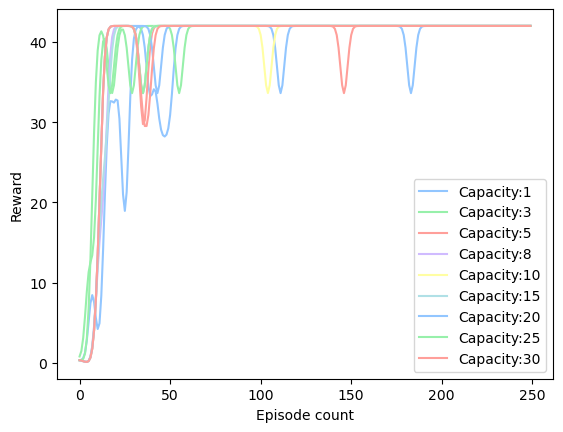

In [114]:
writer_memory = SummaryWriter(log_dir = f'./log/psrl_prox_policy_opt')

for m_size in [1, 3, 5, 8, 10, 15, 20, 25, 30]:
    psrl_AGENT = ProximalPolicyOptimizationAgent(12, 2, memory_capacity=m_size)
    rews = []

    for episode in range(250):
        river_swim = RiverSwim(n, 128)
        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        psrl_AGENT.begin_episode()

        while not is_done:
            action = psrl_AGENT.choose_action(state)
            next_state, reward, is_done = river_swim.step(action)
            psrl_AGENT.update(state, action, reward, next_state)
            state = next_state
            ep_reward += reward    
        
        rews.append(ep_reward)

    writer_memory.add_scalar('Reward/writer_memory', ep_reward, 0)
    filtered_episode_rewards = gaussian_filter1d(rews, sigma=2)
    plt.plot(filtered_episode_rewards, label=f'Capacity:{m_size}')

plt.legend(loc='best')
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './log'

# Results

- Posterior Sampling is indeed useful
- It passes bigger rivers
- Faster training when using memory optimization (since we story previous info)
- It converges fast and does not require crazy machine resources